# Random Walk Classifier
This notebook contains an implementation of a **Random Walk Classifier**, a semi-supervised algorithm that uses Markov chains to make classification predictions from a minimal set of labels.

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_rgba

from sklearn.datasets import make_moons, make_circles
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.base import TransformerMixin, BaseEstimator

sns.set(style='whitegrid')

# Motivation

Situations often arise where we have datasets containing very few labeled samples. Under such circumstances, we may use the small amount of available labels in combination with the inherent structure of the dataset to help classify the unlabeled data.

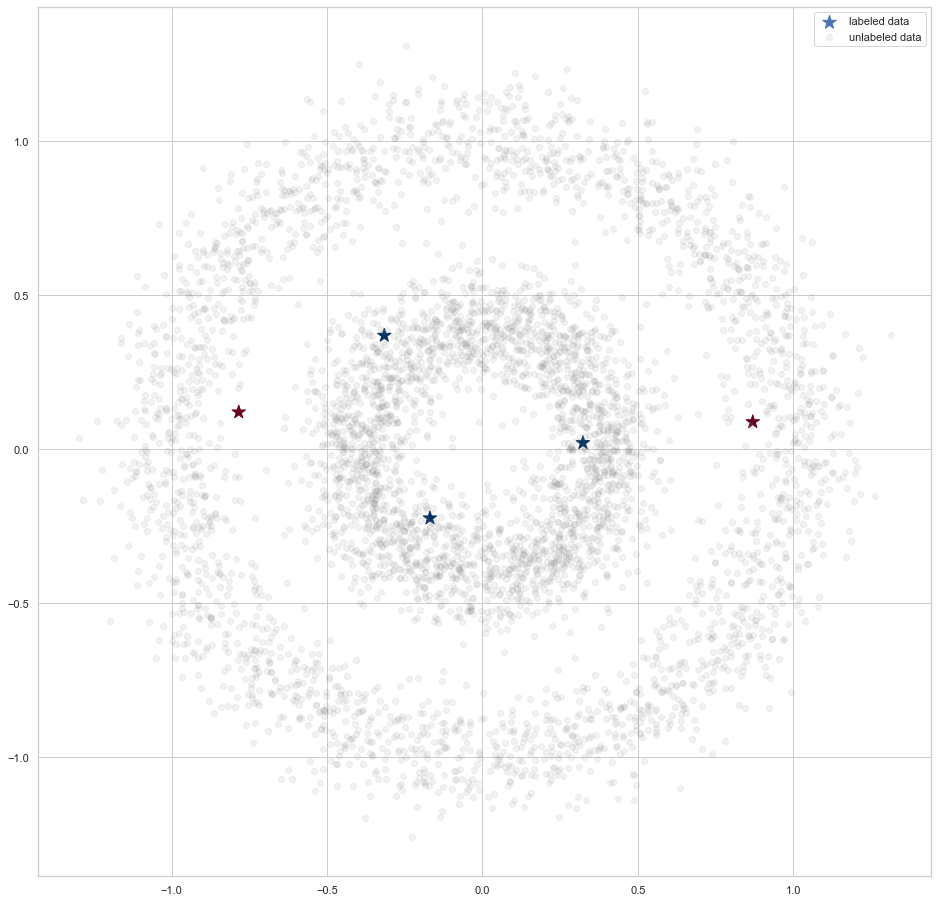

In [71]:
circle_kwargs = dict(noise=0.1, factor=0.4)
X_labeled, y_labeled = make_circles(n_samples=5, **circle_kwargs)
X_unlabeled, y_unlabeled = make_circles(n_samples=5000, **circle_kwargs)

plt.figure(figsize=(16, 16))
plt.scatter(
    *zip(*X_labeled), c=y_labeled, cmap='RdBu', marker='*', s=200,
    label='labeled data')
plt.scatter(
    *zip(*X_unlabeled), color='gray', alpha=0.1, label='unlabeled data')
plt.legend()

# Intuition

Imagine a random walker starting at some initial unlabeled point. At each time step, this walker transitions to some neighboring point with probability inversely proportional to the neighboring point's distance. The walker repeats this process until it transitions to a labeled point, at which time, the initial point the walker started on is assigned the class of the labeled point the walker eventually arrives at.

Of course, random walks are by definition stochastic, so rather than assign the initial point a hard label based on a single walk, we can use a Markov chain to leverage the structure of the dataset to calculate the probability the initial point will be assigned one class or another. A random walk classifier does this for all unlabeled points.

# Mechanics
Let $x_i$ be the i-th sample of the dataset. Define an *unnormalized* transition matrix as:

$$\hat{M}_{ij} = \exp{(-\frac{\|x_i - x_j\|^2}{b})}$$

If $x_i$ and $x_j$ are near each other, $\hat{M}_{ij}$ will be closer to $1$, and if $x_i$ and $x_j$ are farther from each other, $\hat{M}_{ij}$ will be closer to $0$.

However, $\hat{M}$ is not yet a valid matrix of transition probabilities, so we must normalize each row of $\hat{M}$ so that all values in each row sum to $1$. Let's call this normalized matrix $M$. Furthermore, a random walk terminates once arrived at a labeled point, so for every $x_i$ that is a labeled point, we set $M_{ii} = 1$.

If we re-arrange

$$
M = 
\left[
  \begin{array}{cc}
  A & B \\
  0 & I
  \end{array}
\right]
$$

such that $A$ is a submatrix of transition probabilities between unlabeled points, $B$ is a submatrix of transition probabilities between unlabeled and labeled points, and $I$ is the submatrix of transition probabilities between labeled points (an identity matrix), then we can show that:

$$
M^{\infty} = 
\left[
  \begin{array}{cc}
  0 & (I - A)^{-1}B \\
  0 & I
  \end{array}
\right]
$$

The probability that a random walk started at $x_j$ terminates at labeled point $x_i$ is

$$[(I-A)^{-1}B]_{ij}$$

From here, it is trivial to calculate the probability that a random walk started at $x_j$ terminates at a labeled point of class $c$.

In [29]:
class RandomWalkClassifier(TransformerMixin, BaseEstimator):
    
    def __init__(self, beta=0.001):
        """
        Parameters
        ----------
        beta : float
            Controls the bandwidth of the Gaussian kernel applied on the
            Euclidean distance matrix. Smaller values define a sharper,
            narrower kernel.
        """
        self.beta = beta
        
    def fit(self, X, y):
        self.X_labeled = X
        self.y_labeled = y
        self.I = np.eye(len(y))
    
    def predict_proba(self, X):
        A = euclidean_distances(X)
        A = self.gaussian_kernel(A, self.beta)
        B = euclidean_distances(X, X_labeled)
        B = self.gaussian_kernel(B, self.beta)
        A, B = self.col_stack_row_normalize(A, B)
        
        probas = np.linalg.inv(np.eye(len(A)) - A).dot(B)
        probas = pd.DataFrame(probas).T
        probas.index = self.y_labeled
        probas = probas.groupby(level=0).sum()
        probas = probas.T.values
        return probas
        
    def predict(self, X):
        probas = self.predict_proba(X)
        y_pred = np.argmax(probas, axis=1)
        return y_pred
        
    @staticmethod
    def gaussian_kernel(D, beta):
        K = np.exp(D ** 2 / -beta)
        return K
    
    @staticmethod
    def col_stack_row_normalize(A, B):
        row_sums = A.sum(axis=1, keepdims=True) + B.sum(axis=1, keepdims=True)
        A = A / row_sums
        B = B / row_sums
        return A, B

# Test with concentric circles

CPU times: user 14.8 s, sys: 872 ms, total: 15.7 s
Wall time: 2.73 s


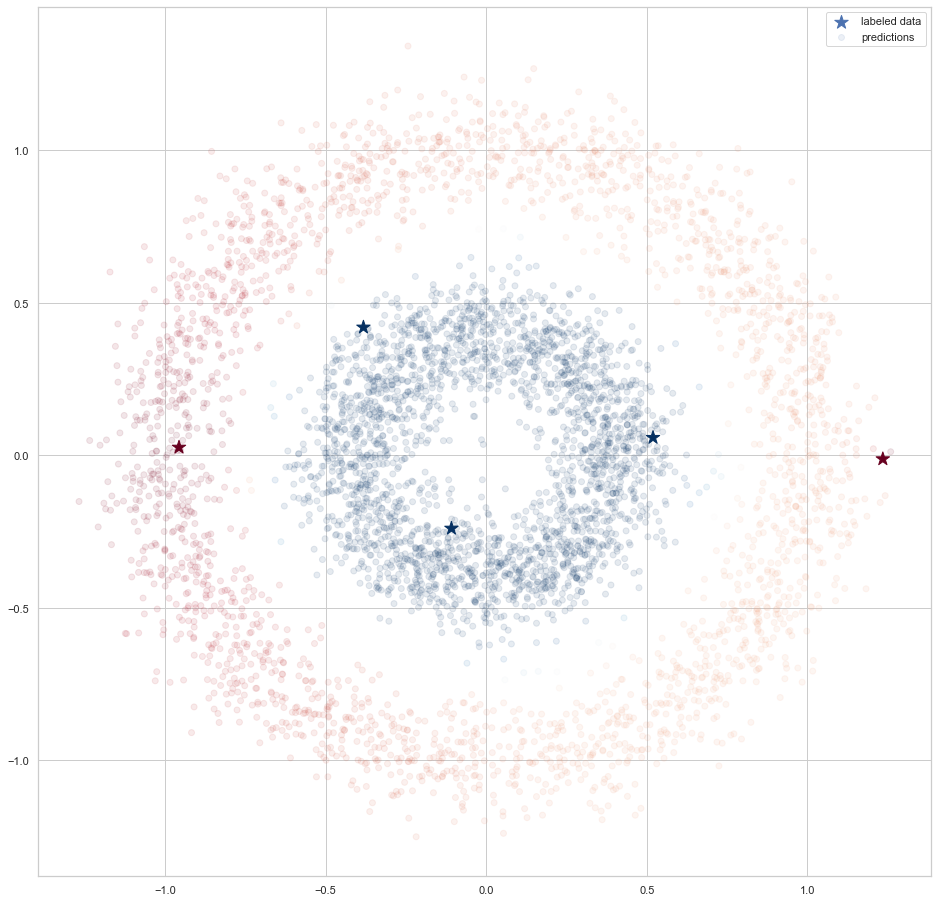

In [65]:
%%time
rwc = RandomWalkClassifier(beta=0.005)
rwc.fit(X_labeled, y_labeled)
y_probas_pred = rwc.predict_proba(X_unlabeled)
y_pred = np.argmax(y_probas_pred, axis=1)

plt.figure(figsize=(16, 16))
plt.scatter(
    *zip(*X_labeled), c=y_labeled, cmap='RdBu', marker='*', s=200,
    label='labeled data')
plt.scatter(
    *zip(*X_unlabeled), alpha=0.1, c=y_probas_pred[:,1], cmap='RdBu',
    label='predictions')
plt.legend()

# Test with moons

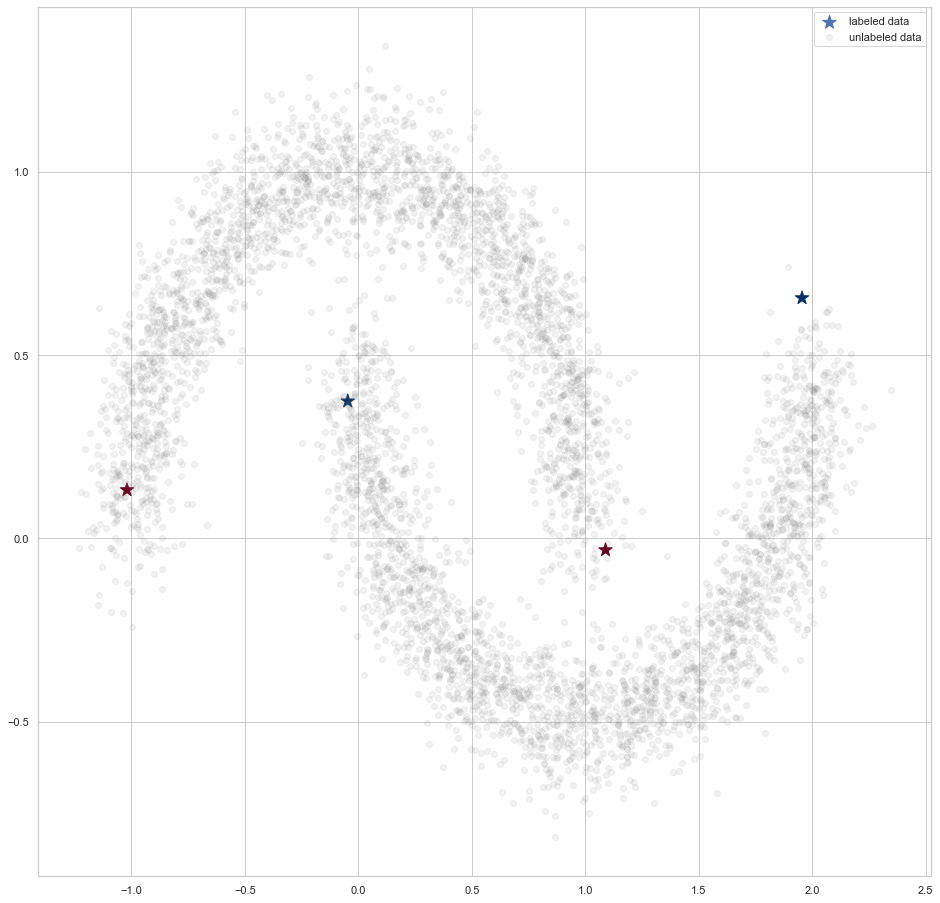

In [68]:
moon_kwargs = dict(noise=0.1)

X_labeled, y_labeled = make_moons(n_samples=4, **moon_kwargs)
X_unlabeled, y_unlabeled = make_moons(n_samples=5000, **moon_kwargs)

plt.figure(figsize=(16, 16))
plt.scatter(
    *zip(*X_labeled), c=y_labeled, cmap='RdBu', marker='*', s=200,
    label='labeled data')
plt.scatter(
    *zip(*X_unlabeled), color='gray', alpha=0.1,
    label='unlabeled data')
plt.legend()

CPU times: user 14.9 s, sys: 881 ms, total: 15.8 s
Wall time: 2.8 s


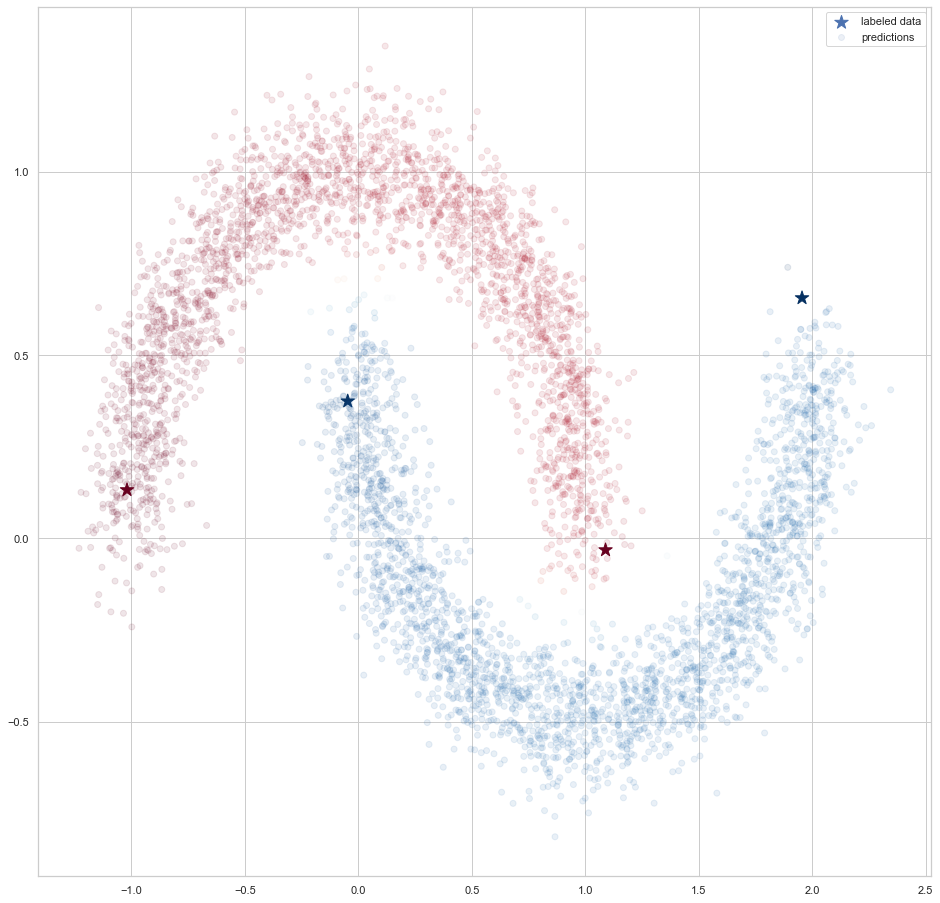

In [69]:
%%time
rwc = RandomWalkClassifier(beta=0.005)
rwc.fit(X_labeled, y_labeled)
y_probas_pred = rwc.predict_proba(X_unlabeled)
y_pred = np.argmax(y_probas_pred, axis=1)

plt.figure(figsize=(16, 16))
plt.scatter(
    *zip(*X_labeled), c=y_labeled, cmap='RdBu', marker='*', s=200,
    label='labeled data')
plt.scatter(
    *zip(*X_unlabeled), alpha=0.1, c=y_probas_pred[:,1], cmap='RdBu',
    label='predictions')
plt.legend()